In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.ksd import ConvolvedKSD
from src.ksd.kernel import RBF, IMQ
from src.ksd.bootstrap import Bootstrap
from experiments.compare_samplers import create_mixture_gaussian
# from experiments.bootstrap_test_convolved import run_bootstrap_experiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
tf.random.set_seed(0)

In [58]:

def run_bootstrap_experiment(nrep, target, proposal_on, proposal_off, convolution, kernel, alpha, num_boot, num_est):
    """compute KSD and repeat for nrep times"""
    ksd = ConvolvedKSD(target=target, kernel=kernel, conv_kernel=convolution)
    
    nsamples_list = [500]
    ksd_df = pd.DataFrame(columns=["n", "p_value", "ksd_hat", "seed", "type"])
    iterator = tqdm(nsamples_list)
    for n in iterator:
        bootstrap = Bootstrap(ksd, n)
        multinom_samples = bootstrap.multinom.sample((nrep, num_boot)) # nrep x num_boot x n
        iterator.set_description(f"Running with sample size {n}")
        for seed in range(nrep):
            iterator.set_description(f"Repetition: {seed+1} of {nrep}")
            # off-target sample
            proposal_off_sample = proposal_off.sample(n)
            conv_sample = convolution.sample(n)
            proposal_off_sample += conv_sample
            _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=proposal_off_sample, multinom_samples=multinom_samples[seed, :], num_est=num_est)
            ksd_df.loc[len(ksd_df)] = [n, p_val, bootstrap.ksd_hat, seed, "off-target"]

            # on-target sample
            proposal_on_sample = proposal_on.sample(n)
            proposal_on_sample += conv_sample
            _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=proposal_on_sample, multinom_samples=multinom_samples[seed, :], num_est=num_est)
            ksd_df.loc[len(ksd_df)] = [n, p_val, bootstrap.ksd_hat, seed, "target"]
    return ksd_df

In [59]:
nrep = 1000
num_boot = 1000 # number of bootstrap samples to compute critical val
alpha = 0.05 # significant level
delta = 4.0
var_list = [50.]#, [1., 5.,]
dim = 1
num_est = 10000 # num samples used to estimate concolved target


In [60]:
res_ls = []
fig = plt.figure(constrained_layout=True, figsize=(5*len(var_list), 9))
subfigs = fig.subfigures(1, len(var_list))
for ind, var in enumerate(var_list):
    print(f"Running with var = {var}")
    # target distribution
    target = create_mixture_gaussian(dim=dim, delta=delta)

    # convolution kernel
    convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))

    # off-target proposal distribution
    proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

    # off-target proposal distribution
    proposal_mean = - delta * tf.eye(dim)[:, 0]
    proposal_off = tfd.MultivariateNormalDiag(proposal_mean)

    # with IMQ
    imq = IMQ(med_heuristic=True)
    test_imq_df = run_bootstrap_experiment(nrep, target, proposal_on, proposal_off, convolution, imq, alpha, num_boot, num_est)
    res_ls.append(test_imq_df)
 
    # plot
    subfig = subfigs.flat[ind]
    subfig.suptitle(f"var = {var}")
    axs = subfig.subplots(3, 1)
    axs = axs.flat
    convolution_sample = convolution.sample(10000)
    axs[0].hist((proposal_off.sample(10000) + convolution_sample).numpy()[:, 0], label="off-target", alpha=0.2)
    axs[0].hist((proposal_on.sample(10000) + convolution_sample).numpy()[:, 0], label="target", alpha=0.2)
    axs[0].legend()

    sns.histplot(ax=axs[1], data=test_imq_df.loc[test_imq_df.type == "off-target"], x="p_value", hue="type", bins=20)
    axs[1].axis(xmin=0., xmax=1.)
    axs[1].set_title("off target")
    axs[1].set_xlabel("p-value")

    sns.histplot(ax=axs[2], data=test_imq_df.loc[test_imq_df.type == "target"], x="p_value", hue="type", bins=20)
    axs[2].axis(xmin=0., xmax=1.)
    axs[2].set_title("On target")
    axs[2].set_xlabel("p-value")

Running with var = 50.0


  0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'SubFigure' object has no attribute 'flat'

<Figure size 360x648 with 0 Axes>

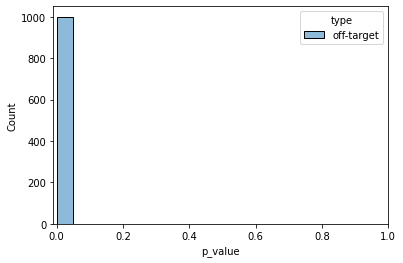

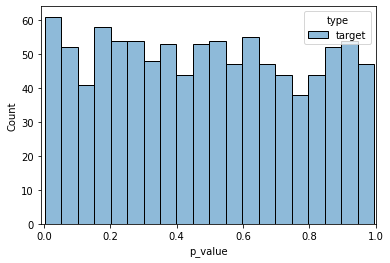

In [61]:
sns.histplot(data=test_imq_df.loc[test_imq_df.type == "off-target"], x="p_value", hue="type", bins=20)
plt.axis(xmin=-0.01, xmax=1.)
plt.show()

sns.histplot(data=test_imq_df.loc[test_imq_df.type == "target"], x="p_value", hue="type", bins=20)
plt.axis(xmin=-0.01, xmax=1.)
plt.show()


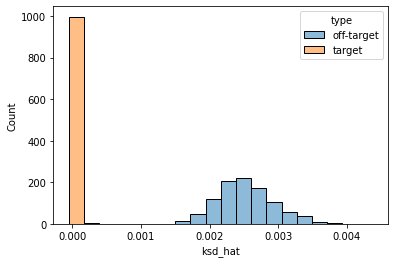

In [62]:
sns.histplot(data=test_imq_df, x="ksd_hat", hue="type", bins=20)
plt.show()


# check bootstrap samples to get intuition

In [ ]:
ksd = ConvolvedKSD(target=target, kernel=imq, conv_kernel=convolution)

ksd_df = pd.DataFrame(columns=["n", "p_value", "ksd_hat", "seed", "type"])
n = 500
bootstrap = Bootstrap(ksd, n)

multinom_samples = bootstrap.multinom.sample((nrep, num_boot)) # nrep x num_boot x n

iterator = trange(nrep)
for seed in iterator:
    iterator.set_description(f"Repetition: {seed+1} of {nrep}")

    # off-target sample
    proposal_off_sample = proposal_off.sample(n)
    conv_sample = convolution.sample(n)
    proposal_off_sample += conv_sample
    _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=proposal_off_sample, multinom_samples=multinom_samples[seed, :], num_est=num_est)
    ksd_df.loc[len(ksd_df)] = [n, p_val, bootstrap.ksd_hat, seed, "off-target"]

    # on-target sample
    proposal_on_sample = proposal_on.sample(n)
    proposal_on_sample += conv_sample
    _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=proposal_on_sample, multinom_samples=multinom_samples[seed, :], num_est=num_est)
    ksd_df.loc[len(ksd_df)] = [n, p_val, bootstrap.ksd_hat, seed, "target"]


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# _ = plt.hist(proposal_on_sample[:, 0].numpy(), density=True)
_ = plt.scatter(proposal_on_sample[:, 0].numpy(), target.prob(proposal_on_sample).numpy())

In [ ]:
plt.hist(ksd_df.loc[ksd_df.type == "target", "p_value"])

In [ ]:
_ = plt.hist(bootstrap.ksd_star.numpy())
plt.vlines(x=bootstrap.ksd_hat, ymin=0., ymax=300., color="red")

In [ ]:
(bootstrap.ksd_star >= bootstrap.ksd_hat).numpy().mean()

In [ ]:
p_val